In [30]:
# %%
# %%
# !pip install pandas numpy matplotlib lifelines

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import os
from config import DATA_ROOT

# Make plots look a bit nicer
plt.style.use("default")

# %%
# 1. Read CSV
# --------------------------------------------------------------------
# Set CSV path here:

csv_path = os.path.join(DATA_ROOT, "original_data.csv")  #

df_raw = pd.read_csv(csv_path)

print("Raw shape:", df_raw.shape)
df_raw.head()
# ---- compute PRS time ----
df = df_raw.copy()

Raw shape: (272, 120)


In [31]:
csv_path = os.path.join(DATA_ROOT, "original_data.xlsx")  
df_raw = pd.read_excel(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,2021-04-05,56.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,2025-03-21,35.333333,48.200000,12.866667,9.200000,3.666667,9.200000
1,2,3,"PGIMER, Chandigarh, India",SRS,2018-08-10,38.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,2024-09-18,17.900000,74.366667,56.466667,55.766667,0.700000,55.766667
2,3,1,Dokkyo Medical Universiry,SRS,2015-02-23,47.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,2015-10-22,4.800000,8.033333,3.233333,2.833333,0.400000,2.833333
3,4,7,Dokkyo Medical Universiry,SRS,2016-02-05,74.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,2017-09-16,9.466667,19.633333,10.166667,9.033333,1.133333,9.033333
4,5,13,Dokkyo Medical Universiry,SRS,2017-06-28,75.0,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,2020-11-06,25.733333,40.900000,15.166667,14.766667,0.400000,14.766667


In [32]:
# Time points for survival analysis
# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"
# create mapping from original column names to standardized names
col_mapping = {
    "Date of first recurrence per RANO (date of MRI)": "recurrence_date",
    "Date of death or last follow-up": "death_or_lastFU_date",
    "Death (1: yes / 0: no)": "event_death",
    "Age at diagnosis": "age_dx",
    "KPS before SRS or re-RT for Recurrence": "kps_pre",
    "Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)": "ce_volume_cm3",
    "SRS Dose (Gy)": "srs_dose_gy"
}

df = df.rename(columns=col_mapping)

time_points = [col_mapping[tp] for tp in time_points]
variables = [col_mapping[var] for var in variables]

# read in variables
# df = df[time_points + variables].copy()
for col in time_points:
    # check if there is any missing data
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
# add a new column to calculate survival time
df["Survival Time (days)"] = (pd.to_datetime(df["death_or_lastFU_date"]) - pd.to_datetime(df["recurrence_date"])).dt.days

for col in variables:
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
    # if missing, fill with median or mode
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# read a survival event column
df["Event Observed"] = df_raw["Death (1: yes / 0: no)"].astype(bool)
missing_count = df["Event Observed"].isnull().sum()
print(f"Missing values in 'Event Observed': {missing_count}")

# survival time prediction
df = df[df["Survival Time (days)"] >= 0]  # remove negative survival times
print("Processed shape:", df.shape)

# use survivaltree to predict survival


df.head()



Missing values in 'recurrence_date': 0
Missing values in 'death_or_lastFU_date': 0
Missing values in 'age_dx': 0
Missing values in 'kps_pre': 5
Missing values in 'ce_volume_cm3': 16
Missing values in 'srs_dose_gy': 1
Missing values in 'Event Observed': 0
Processed shape: (272, 122)


/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_16093/757976520.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Survival Time (days)"] = (pd.to_datetime(df["death_or_lastFU_date"]) - pd.to_datetime(df["recurrence_date"])).dt.days
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_16093/757976520.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Survival Time (days)"] = (pd.to_datetime(df["death_or_lastFU_date"]) - pd.to_datetime(df["recurrence_date"])).dt.days
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_16093/757976520.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The beha

,b,#,Center,by,Date of first diagnosis (date of first surgery),age_dx,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,event_death,death_or_lastFU_date,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression,Survival Time (days),Event Observed
0,1,2,"PGIMER, Chandigarh, India",SRS,04/2021,56,F,Glioblastoma,WT,NaN,...,0,03/2025,35.3,48.2,12.9,9.2,3.7,9.2,394,False
1,2,3,"PGIMER, Chandigarh, India",SRS,08/2018,38,M,Glioblastoma,WT,NaN,...,0,09/2024,17.9,74.4,56.5,55.8,0.7,55.8,1705,False
2,3,1,Dokkyo Medical Universiry,SRS,02/2015,47,F,Glioblastoma,WT,NaN,...,1,10/2015,4.8,8.0,3.2,2.8,0.4,2.8,92,True
3,4,7,Dokkyo Medical Universiry,SRS,02/2016,74,M,Glioblastoma,WT,NaN,...,1,09/2017,9.5,19.6,10.2,9.0,1.1,9.0,304,True
4,5,13,Dokkyo Medical Universiry,SRS,06/2017,75,M,Glioblastoma,WT,NaN,...,0,11/2020,25.7,40.9,15.2,14.8,0.4,14.8,458,False


'''
create a model to predictive PRS(post-recurrence survival) in patients, the PRS survival time is defined as the time from recurrence to death
 recurrence: "Date of first recurrence per RANO (date of MRI)", death: "Date of death or last follow-up". variables can be used "Age at diagnosis,
KPS before SRS or re-RT for Recurrence,
Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),
SRS Dose (Gy)"
'''

In [33]:
from sksurv.util import Surv
from sksurv.tree import SurvivalTree
from sksurv.metrics import concordance_index_censored



#
# Prepare data for survival tree
y_structured = Surv.from_dataframe("Event Observed", "Survival Time (days)", df)
X = df[variables]
# Fit survival tree

min_samples_leaf = 25
min_samples_split = 50
max_depth = 4

surv_tree = SurvivalTree(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
surv_tree.fit(X, y_structured)
# Predict risk scores
risk_scores = -surv_tree.predict(X)  # negative because higher risk should correspond to lower survival



In [34]:
from sklearn.tree import plot_tree
import graphviz
from sklearn.tree import export_graphviz

# # 2. Plot the tree
# plt.figure(figsize=(15, 10))
# plot_tree(
#     surv_tree, 
#     feature_names=X.columns, 
#     filled=True, 
#     rounded=True, 
#     fontsize=10
# )
# plt.title("RPA Stratification Tree")
# plt.show()

In [35]:
print(surv_tree.tree_)

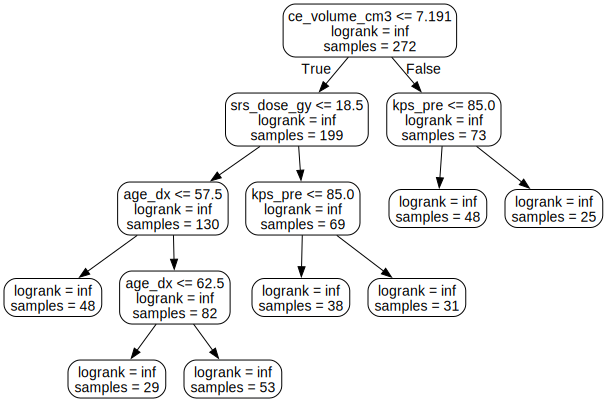

In [ ]:
import re
surv_tree.criterion = "logrank" 

# 2. Export the tree structure to DOT format
dot_data = export_graphviz(
    surv_tree,
    out_file=None,
    feature_names=X.columns,
    filled=False, # Must be False to prevent the float NaN error
    rounded=True
)

# 3. Render and view the tree
# dot_data_cleaned = re.sub(r'value\s*=\s*\[.*?\][^\n]*\n', '', dot_data, flags=re.DOTALL)

cleaned_lines = []
for line in dot_data.split('\n'):
    # Check if the line contains the "value =" string
    # print(line)
    if "value =" in line:
        # print(line)
        idx_value = line.index("value =") -2
        idx_last_bracket = line.rindex("]")-2
        # print(len(line))
        # print(idx_value, idx_last_bracket)
        cleaned_lines.append(line[:idx_value] + line[idx_last_bracket+1:])
        # print(cleaned_lines[-1])
        # break
    else:
        cleaned_lines.append(line)
dot_data_manual = '\n'.join(cleaned_lines)

# print(dot_data_manual)

graph = graphviz.Source(dot_data_manual)
graph.render("./survival_tree.pdf")  # Saves as survival_tree.pdf
graph  # Displays in Jupyter/Colab

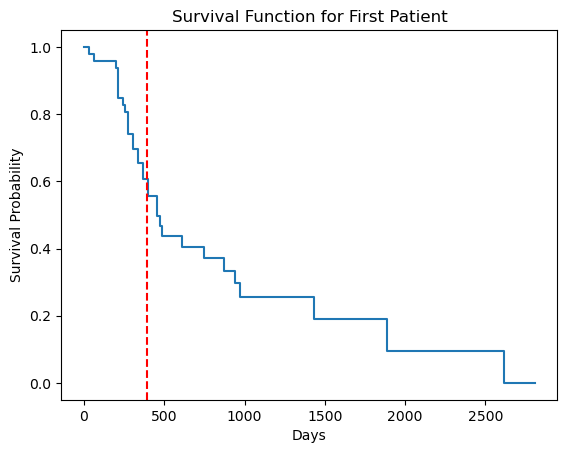

In [39]:
# plot survival curve for the first patient
surv_func = surv_tree.predict_survival_function(X.iloc[[0]])
for fn in surv_func:
    plt.step(fn.x, fn.y, where="post")
# plot actual survival curve
actual_times = df.iloc[0]["Survival Time (days)"]
actual_event = df.iloc[0]["Event Observed"]
plt.axvline(x=actual_times, color="r", linestyle="--", label="Actual Survival Time")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.title("Survival Function for First Patient")
plt.show()

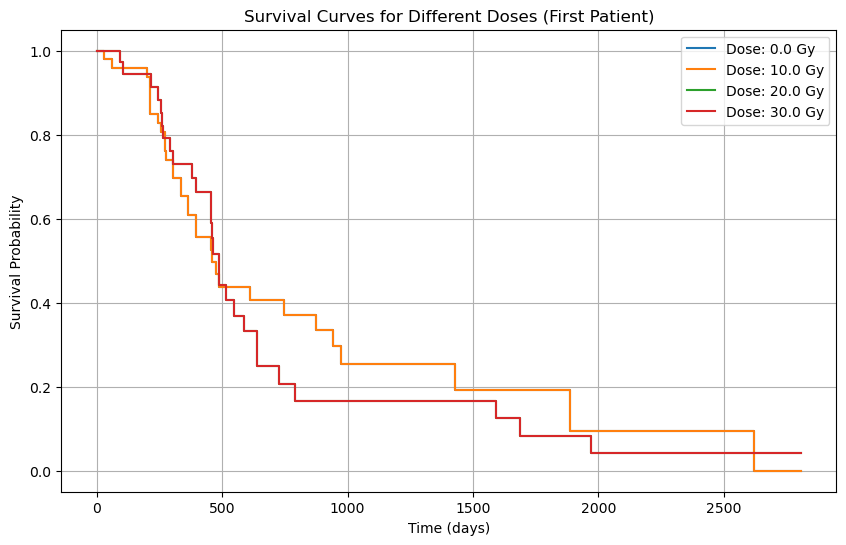

In [42]:
# Evaluate concordance index
c_index = concordance_index_censored(df["Event Observed"], df["Survival Time (days)"], risk_scores)
# print("Concordance Index:", c_index[0]) 

# predict survival function for a given patient and dose
def best_dose_by_survival_at_t(surv_tree, x0, doses, t_star):
    S = []
    for d in doses:
        x0_dose = x0.copy()
        x0_dose["srs_dose_gy"] = d
        surv_func = surv_tree.predict_survival_function(x0_dose)
        # print(surv_func)
        S_t = surv_func[0](t_star)  # survival probability at time t_star
        S.append(S_t)
        # print(S_t)
    S = np.array(S)
    best_dose = doses[np.argmax(S)]
    return best_dose, S.max(), S

# predict survival time based on different doses, draw survival curve
def best_dose_by_survival_curve(surv_tree, x0, doses):
    S = []
    for d in doses:
        x0_dose = x0.copy()
        x0_dose["srs_dose_gy"] = d
        surv_func = surv_tree.predict_survival_function(x0_dose)
        S.append(surv_func[0])
    return doses, S
# Example usage:
# dose grid (choose clinically valid bounds/step)
doses = np.linspace(0, 30, 61)  # 0..70 Gy in 0.5 Gy steps


x0 = X.iloc[[0]].copy()
best_dose, best_survival, survival_all = best_dose_by_survival_at_t(surv_tree, x0, doses, t_star=180)
doses, survival_funcs = best_dose_by_survival_curve(surv_tree, x0, doses)
plt.figure(figsize=(10, 6))
for i, d in enumerate(doses[::20]):  # plot every 20th dose
    plt.step(survival_funcs[i*20].x, survival_funcs[i*20].y, where="post", label=f"Dose: {d} Gy")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Survival Curves for Different Doses (First Patient)")
plt.legend()
plt.grid()
plt.show()
